# Introduction

## Technical details
To do this analysis, we need to overcome some technical aspects:
- Test a Bayesian model at the suburban level
- Model accessibility at the meshblock level
- Gather modeled meshblock accessibilities at the suburban level
- Compare suburban averages in Wellington


In [1]:
# Import some packages
import warnings
import pandas as pd
import osmnx as ox 
import networkx as nx
import pandana as pa

import geopandas 
import numpy as np
import seaborn as sns
import folium
import yaml
from importlib import reload
from shapely.geometry import Point, Polygon, LineString
from descartes import PolygonPatch
import matplotlib.pyplot as plt
import pystan

import utils.data_processing as dp
import utils.accessibility_analysis as aa
import utils.util as ut
import utils.stan_utils as su

# Some configs
warnings.filterwarnings('ignore')
ox.config(log_console=True, use_cache=True)
pd.set_option('display.max_columns', 200)
%matplotlib inline

In [2]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
# Copied from http://boundingbox.klokantech.com/
general_bbox = [174.57,-41.38,174.84,-41.1527]

# Separate out the bounding box list into 4 vertices. 
south = general_bbox[1]
west = general_bbox[0]
north = general_bbox[3]
east = general_bbox[2]

# Set OSM bounding box
osm_bbox = [south, west, north, east]

# centroids of bounding box
mean_lat = np.mean([north, south])
mean_lon = np.mean([west, east])

# Datasets

| Dataset | Description | Format | Link |
| :-----: | :---------: | :----: | :--: |
| WCC playground locations | jsdh | .zip| |
| WCC suburb boundaries | ;lf | .gdb | |
| StatsNZ 2019 meshblock boundaries | ;lf | .gdb | |
| Wellington street network without elevation | ksfj| kjfd | lkd| 
| Wellington street network with elevation | ksfj| kjfd | lkd| 

## WCC Playgrounds

In [3]:
wcc_playgrounds = geopandas.read_file('zip://./data/WCC_Playgrounds.zip')
wcc_playgrounds['lon'] = wcc_playgrounds['geometry'].apply(lambda p: p.x)
wcc_playgrounds['lat'] = wcc_playgrounds['geometry'].apply(lambda p: p.y)
wcc_playgrounds = wcc_playgrounds.to_crs(epsg=4167)

In [4]:
map_playground = folium.Map(location=[mean_lat, mean_lon], zoom_start = 11)

for each in wcc_playgrounds.iterrows():
    folium.Marker(location = [each[1]['lat'],each[1]['lon']]).add_to(map_playground)

map_playground

## Boundary files: Suburbs and meshblocks

In [5]:
wcc_suburbs = geopandas.read_file('zip://./data/WCC_Suburbs_Boundaries.zip')
meshblock= geopandas.read_file('./data/meshblock-higher-geographies-2019-generalised-4326.gdb')
wlg_meshblock = meshblock.query('REGC2019_V1_00_NAME == "Wellington Region"')

# Two different types of joining operations
wlg_meshblock_suburbs = geopandas.sjoin(wcc_suburbs, wlg_meshblock, op='contains', how='right')
wlg_meshblock_suburbs_ov = geopandas.overlay(wcc_suburbs, wlg_meshblock, how='identity')

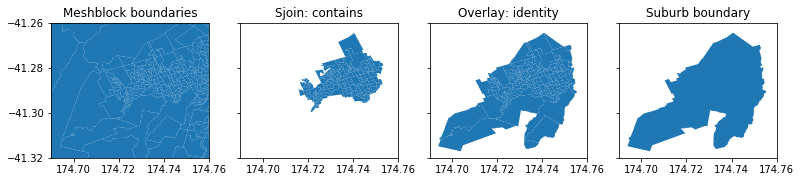

In [6]:
# Set up figure
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(13,10))

# Plot meshblocks contained within suburb boundary
wlg_meshblock.plot(ax=ax1)
plt.ylim(-41.320, -41.260)
plt.xlim(174.69, 174.76)
ax1.set_title('Meshblock boundaries');

# Plot meshblocks contained within suburb boundary
wlg_meshblock_suburbs.query('suburb == "Karori"').plot(ax=ax2)
plt.ylim(-41.320, -41.260)
plt.xlim(174.69, 174.76)
ax2.set_title('Sjoin: contains');

# Plot meshblocks intersecting with suburb boundary
wlg_meshblock_suburbs_ov.query('suburb == "Karori"').plot(ax=ax3)
plt.ylim(-41.320, -41.260)
plt.xlim(174.69, 174.76)
ax3.set_title('Overlay: identity');

# Suburb boundary within meshblock limits
wcc_suburbs.query('suburb == "Karori"').plot(ax=ax4)
plt.ylim(-41.320, -41.260)
plt.xlim(174.69, 174.76)
ax4.set_title('Suburb boundary');

## Wellington street network: without elevation
Getting the Wellington street network in a form suitable for accessibility analysis is trivial. The previous posts [on fuel station](https://shriv.github.io/Fuel-Stations-Analysis-Part-3/) and [playground](https://shriv.github.io/Playgrounds-vs-pubs/) acessibility cover the process in detail. Without delving into the specifics, the process basically involves calling _pandana's_ OpenStreetMap loader. And voila, we have a street network that can be consumed by _pandana_ for the accessibility analysis. 

In [7]:
# Set some parameters for accessibility analysis
n = 1 # nth closest nodes to fuel station. n = 1 means the closest.
distance = 5000.0 # distance bound for accessibility calculation; impedance limit.
num_pois = 10

# Plotting parameters
bbox_aspect_ratio = (osm_bbox[2] - osm_bbox[0]) / (osm_bbox[3] - osm_bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

bmap_kwargs={'epsg':'4167','resolution':'f'}
plot_kwargs={'cmap':'viridis_r','s':4,'edgecolor':'none'}

The _pandana_ network above has edge weights in the default units of metres, which means that the accessibility analyses will also be in metres. We can post-hoc convert the distance units to travel time with an average walking speed of 5 km/h or, 83 m/minute if we want travel time in minutes. 

## Wellington street network: with elevation

In [8]:
# Open the API keys stored in a YAML file
with open("utils/api_keys.yaml", 'r') as stream:
    data_loaded = yaml.load(stream)

# Get Google Elevation API key
google_elevation_api_key = data_loaded['google_elevation_api_key'][0]

# Create an OSMNX walking street netwoek for the Wellington bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type='walk')

# Add elevation values for the nodes in the OSMNX graph
G = ox.add_node_elevations(G, api_key=google_elevation_api_key)

# Generate an edge grade (inclination) with the elevations at the nodes
G = ox.add_edge_grades(G)

# Accessibility analysis using network with street gradients

## Reproducing existing accessibility analysis

In [9]:
# Get nodes and edges as geodataframes (gdfs) from OSMNX network
graph_df = ox.graph_to_gdfs(G)
nodes_gdfs = graph_df[0]
edges_gdfs = graph_df[1]

In [10]:
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'

## Pandana network with travel times

In [11]:
# Break up network
edges_gdfs_undir_inv, edges_gdfs_undir, nodes_gdfs = dp.separate_elevation_graph_by_direction(G)

# Create pandana network objects for flat and hilly terrain travel times
network = pa.Network(nodes_gdfs['x'], nodes_gdfs['y'],
                     edges_gdfs_undir['u'], edges_gdfs_undir['v'], 
                     edges_gdfs_undir[['time_5khr']])

network_hills = pa.Network(nodes_gdfs['x'], nodes_gdfs['y'],
                           edges_gdfs_undir['u'], edges_gdfs_undir['v'], 
                           edges_gdfs_undir[['time_tobler']])

network_hills_inv = pa.Network(nodes_gdfs['x'], nodes_gdfs['y'],
                               edges_gdfs_undir_inv['u'], edges_gdfs_undir_inv['v'], 
                               edges_gdfs_undir_inv[['time_tobler']])

## Pandana accessibility with hill-accounted travel times

In [12]:
# Calculate accessibility
playground_accessibility = aa.get_accessibility(network, wcc_playgrounds, distance=30, num_pois=10)
playground_hills_accessibility = aa.get_accessibility(network_hills, wcc_playgrounds, distance=30, num_pois=10)
playground_hills_inv_accessibility = aa.get_accessibility(network_hills_inv, wcc_playgrounds, distance=30, num_pois=10)

In [13]:
total_flat = (playground_accessibility[1] + playground_accessibility[1])
total_hills_1 = (playground_hills_inv_accessibility[1] + playground_hills_accessibility[1])
total_hills_2 = (playground_hills_inv_accessibility[2] + playground_hills_accessibility[2])

In [14]:
def filtered_accessibility_network(pandana_network, filtered_accessibility):

    network_nodes = pandana_network.nodes_df.reset_index()
    new_network_nodes = []
    for node in filtered_accessibility.reset_index()['id'].tolist():
        val = network_nodes[network_nodes['id'] == node]
        new_network_nodes.append(val)
    
    new_network_nodes = pd.concat(new_network_nodes).set_index('id')
    pandana_network.nodes_df = new_network_nodes
    return pandana_network, filtered_accessibility


# Accessibility by Wellington suburb

## Distributions within populous SA2 units

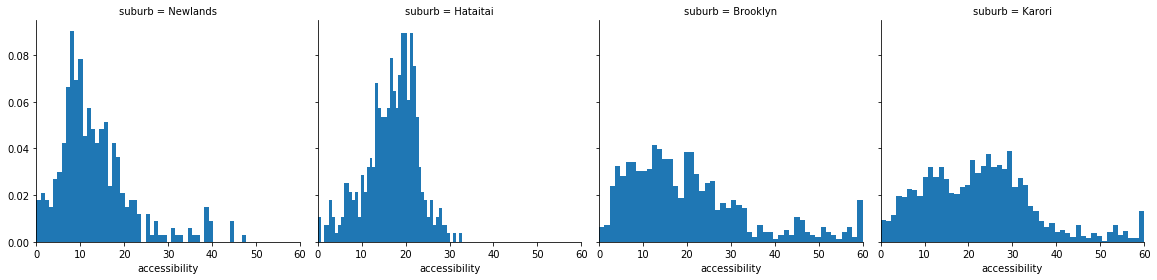

In [15]:
# Get lat and lon coordinates for accessibility values
orig_nodes = network_hills.nodes_df 
df_joined = pd.merge(orig_nodes.reset_index(), total_hills_1.reset_index(), how='inner')
df_joined.columns = ['node_id', 'lon', 'lat', 'accessibility']
# Convert lat and lon to geoseries
df_joined_coords = dp.coords_df_to_geopandas_points(df_joined, crs={'init': 'epsg:4167'})


playground_df = geopandas.sjoin(wcc_suburbs, df_joined_coords, op='contains').drop('index_right', axis=1)


#df_sel = playground_df[playground_df['AU2013_V1_00_NAME'].isin(['Karori Park', 'Te Kainga',
#                                          'Karori South', 'Karori East',
#                                         'Newlands South', 'Hataitai North', 
#                                          'Strathmore Park', 'Raroa',
#                                         'Ngaio South', 'Brooklyn'])]

df_sel = playground_df[playground_df['suburb'].isin(['Karori','Newlands', 'Hataitai', 'Strathmore','Brooklyn'])]

g = sns.FacetGrid(col='suburb', data=df_sel, size=4, col_wrap=5)
g.map(plt.hist, 'accessibility', normed=True, bins=50)
plt.xlim(0,60);
#plt.ylim(0, 0.0035);

## Visualising accessibility with composite SA2 boundaries

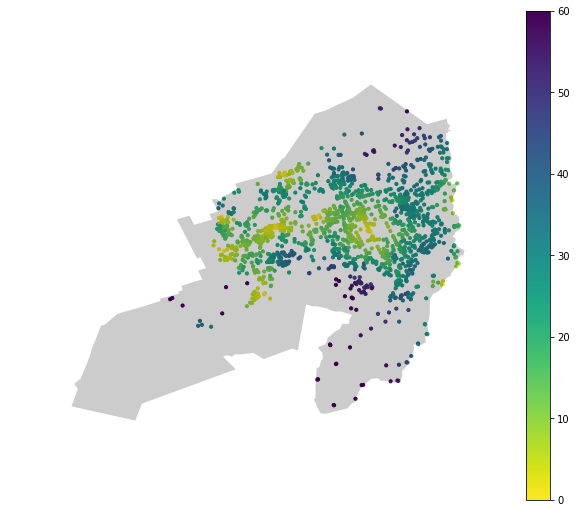

In [16]:
karori = playground_df[playground_df['suburb'] == 'Karori']
karori_mesh = wlg_meshblock_suburbs[wlg_meshblock_suburbs['suburb'] == "Karori"]

fig = plt.figure(figsize=(10,9))
#f, ax = plt.subplots()
ax = fig.add_subplot(1,1,1)
a0 = ax.scatter(karori['lon'], 
                karori['lat'], 
                s=10,
                c=karori['accessibility'],
                cmap='viridis_r')

#wlg_meshblock_suburbs[wlg_meshblock_suburbs['suburb'] == 'Karori'].plot(ax=ax, alpha=0.9)    
wcc_suburbs[wcc_suburbs['suburb'] == 'Karori']['geometry'].plot(ax=ax, color='black', alpha=0.2)   

cbar1 = fig.colorbar(a0, ax=ax)
ax.axis('off')
cbar1.set_clim(0, 60)
plt.show()

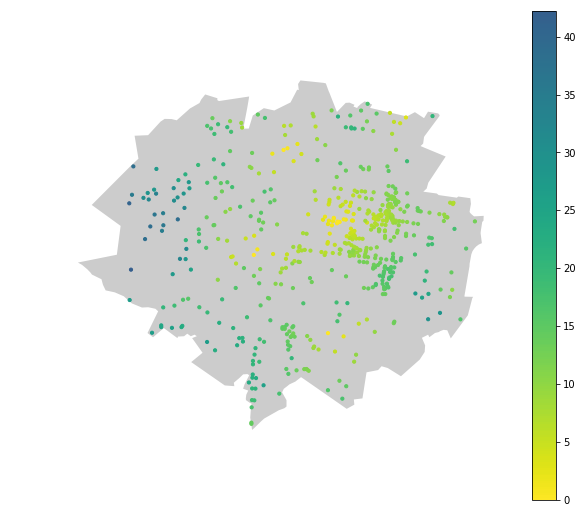

In [17]:
jville = playground_df[playground_df['suburb'] == 'Johnsonville']

fig = plt.figure(figsize=(10,9))
#f, ax = plt.subplots()
ax = fig.add_subplot(1,1,1)

wcc_suburbs[wcc_suburbs['suburb'] == 'Johnsonville']['geometry'].plot(ax=ax, color='black', alpha=0.2)    
#wlg_meshblock_suburbs[wlg_meshblock_suburbs['suburb'] == 'Johnsonville'].plot(ax=ax)    

a0 = ax.scatter(jville['lon'], 
                jville['lat'], 
                s=10,
                c=jville['accessibility'],
                cmap='viridis_r')

cbar1 = fig.colorbar(a0, ax=ax)
cbar1.set_clim(0, 60)
ax.axis('off')
plt.show()

In [18]:
# wlg_meshblock_acc = geopandas.sjoin(wlg_meshblock,  df_joined_coords, op='contains')

In [19]:
# wlg_meshblock_acc['SA22019_V1_00_NAME'].value_counts().head()

In [20]:
# wlg_meshblock_acc['SA22019_V1_00_NAME'].value_counts().tail()

# Stan experiments
This section is all about writing Bayesian models with Stan. 

In [21]:
uni_norm_model = su.load_or_generate_stan_model('stan', 'univariate_normal')
lower_trunc_norm_model = su.load_or_generate_stan_model('stan', 'lower_truncated_univariate_normal')
trunc_norm_model = su.load_or_generate_stan_model('stan', 'truncated_univariate_normal')


stan/univariate_normal.pkl
stan/lower_truncated_univariate_normal.pkl
stan/truncated_univariate_normal.pkl


In [22]:
# Run precompiled model
hataitai = playground_df[playground_df['suburb'] == 'Hataitai']
karori = playground_df[playground_df['suburb'] == 'Karori']
karori = karori[karori['accessibility'] > 0]

karori_dat = {'n': karori.shape[0],
              'y': karori['accessibility'].values,}
karori_fit = uni_norm_model.sampling(karori_dat, chains=4)
print(karori_fit)


Inference for Stan model: anon_model_cc3fc1beb21cbbe7b94ad66105c98210.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      22.61  5.6e-3   0.32  21.96   22.4  22.61  22.82  23.25   3285    1.0
sigma   12.62  3.9e-3   0.22  12.21  12.47  12.61  12.76  13.08   3176    1.0
y_pred  22.58    0.21  12.67  -2.36  14.14  22.53  30.96   47.4   3803    1.0
lp__    -4887    0.03   1.03  -4890  -4888  -4887  -4887  -4886   1678    1.0

Samples were drawn using NUTS at Thu Mar  7 13:12:42 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


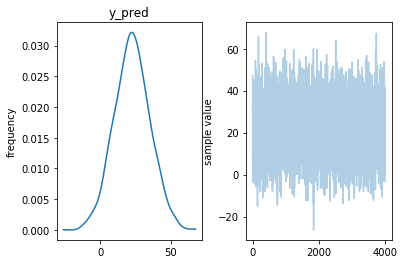

In [23]:
fig = karori_fit.plot(pars=['y_pred'])
fig.subplots_adjust(hspace=1.0, wspace=0.3)

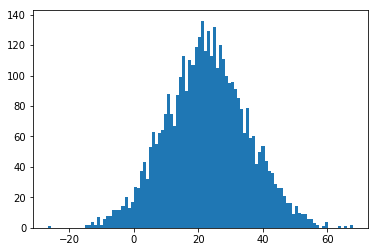

In [24]:
plt.hist(karori_fit['y_pred'], bins=100);

In [25]:
# Run precompiled model
hataitai = playground_df[playground_df['suburb'] == 'Hataitai']

hataitai_dat = {'n': hataitai.shape[0],
                'y': hataitai['accessibility'].values,}
hataitai_fit = uni_norm_model.sampling(hataitai_dat, chains=4)
print(hataitai_fit)


Inference for Stan model: anon_model_cc3fc1beb21cbbe7b94ad66105c98210.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      16.79  4.8e-3   0.28  16.22  16.59  16.79  16.98  17.35   3553    1.0
sigma    5.89  3.3e-3    0.2   5.53   5.75   5.89   6.02   6.29   3643    1.0
y_pred  16.64    0.09   5.86   5.46  12.68   16.6  20.48  28.35   4000    1.0
lp__   -963.7    0.02   0.96 -966.3 -964.1 -963.4 -963.0 -962.8   2103    1.0

Samples were drawn using NUTS at Thu Mar  7 13:12:43 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


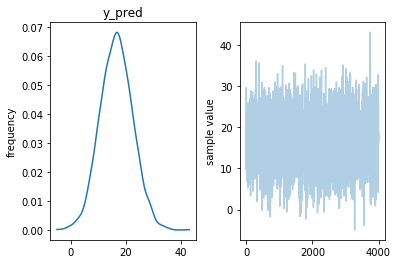

In [26]:
fig = hataitai_fit.plot(pars=['y_pred'])
fig.subplots_adjust(hspace=1.0, wspace=0.3)

## Truncated Normal

In [27]:
# Run precompiled model
karori_trunc_dat = {'N': karori.shape[0],
                    'L': 0,
                    'U': 80,
                    'y': karori['accessibility'].values,}
karori_trunc_fit = lower_trunc_norm_model.sampling(karori_trunc_dat, chains=4)
print(karori_trunc_fit)


Inference for Stan model: anon_model_6b9395850f704e0b6115df3ea3add7ea.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      20.04    0.01   0.52   19.0   19.7  20.05   20.4  21.03   1813    1.0
sigma   14.75  9.5e-3    0.4  13.99  14.47  14.73  15.01  15.56   1770    1.0
y_pred  22.52     0.2  12.51   2.15  12.96  21.44  30.81  49.54   4000    1.0
lp__    -4801    0.03   1.09  -4804  -4801  -4801  -4800  -4800   1708    1.0

Samples were drawn using NUTS at Thu Mar  7 13:12:49 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


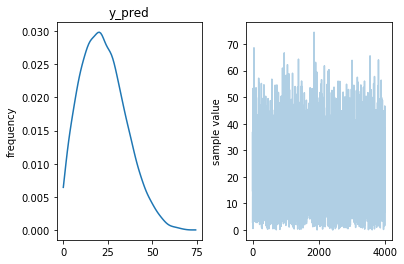

In [28]:
fig = karori_trunc_fit.plot(pars=['y_pred'])
fig.subplots_adjust(hspace=1.0, wspace=0.3)

## Checking model performance with posterior predictive

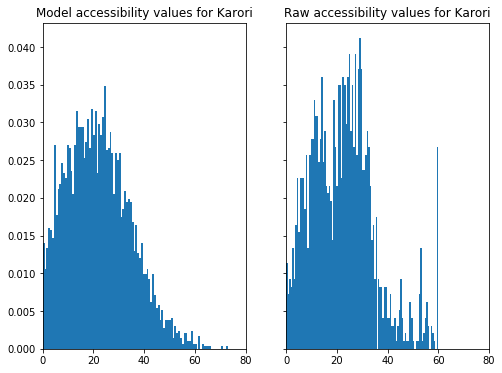

In [82]:
karori_fit = su.run_plot_suburb_stan(playground_df, lower_trunc_norm_model)

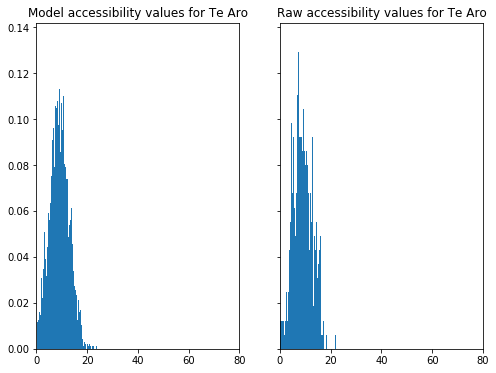

In [83]:
tearo_fit = su.run_plot_suburb_stan(playground_df, lower_trunc_norm_model, 'Te Aro')

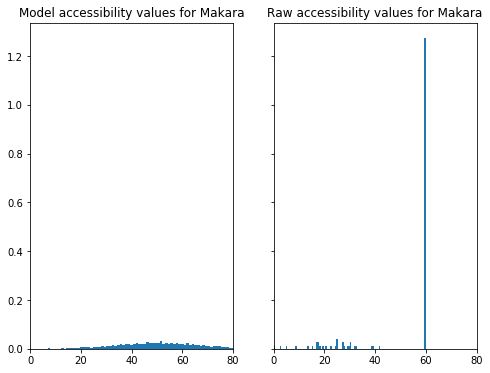

In [84]:
makara_fit = su.run_plot_suburb_stan(playground_df, lower_trunc_norm_model, 'Makara')

## Hierarchical modelling

In [32]:
norm_hier_model = su.load_or_generate_stan_model('stan', 'univariate_normal_hierarchical_single_level')

stan/univariate_normal_hierarchical_single_level.pkl


In [68]:
summary_df = playground_df['suburb'].value_counts().reset_index().rename({'suburb': 'counts',
                                                                         'index': 'suburb'}, axis=1)
summary_df['cumulative'] = summary_df['counts'].cumsum()
summary_df['fraction'] = summary_df['cumulative'] / summary_df['counts'].sum()

top_90 = summary_df[summary_df['fraction'] <= 0.90]
top_90.head()

,suburb,counts,cumulative,fraction
0,Karori,1619,1619,0.104702
1,Miramar,1207,2826,0.182759
2,Brooklyn,800,3626,0.234495
3,Te Aro,742,4368,0.282481
4,Newtown,729,5097,0.329626


In [66]:
hier_summary_2 = su.train_acc_hierarchical(playground_df[playground_df['suburb'].isin(top_90['suburb'])]
                                             , norm_hier_model
                                             , return_levels_stanfit = True) 

In [67]:
hier_summary_2

{'stanfit': Inference for Stan model: anon_model_7ef0b9fb63c25ae34984eb34b1fc4634.
 1 chains, each with iter=1000; warmup=500; thin=1; 
 post-warmup draws per chain=500, total post-warmup draws=500.
 
               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
 mu_l[0]       9.14    0.03   0.54   7.87   8.84   9.19   9.49  10.11    349    1.0
 mu_l[1]        8.9    0.09    1.5   5.67   7.96   9.08   9.98  11.25    264    1.0
 mu_l[2]      26.28    0.08   1.68  22.96  25.22  26.39  27.45  29.39    500    1.0
 mu_l[3]      11.52    0.02   0.49  10.57  11.18  11.54  11.86  12.37    500    1.0
 mu_l[4]      11.29    0.02   0.46  10.29  11.02   11.3   11.6  12.12    500    1.0
 mu_l[5]       9.28    0.09   1.31   6.59   8.49   9.31  10.22  11.62    236    1.0
 mu_l[6]       20.6    0.03    0.7  19.24  20.11  20.63   21.1  21.97    500    1.0
 mu_l[7]      58.68    0.03   0.57  57.45  58.31  58.73  59.12  59.64    500    1.0
 mu_l[8]      15.94    0.03   0.73  14.48  